### Library Import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sktime



from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
)

from sktime.utils import plotting


from sklearn.linear_model import (
    LinearRegression,
    ElasticNetCV,
    MultiTaskElasticNetCV,
    MultiTaskElasticNet,
    RidgeCV,
    LassoCV,
    HuberRegressor,
)

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
from src.load_datasets import load_air_polution_data

dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="date")
    .pipe(set_index, col="date")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_Data, freq="D")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (1825, 7)
dataframe shape (1825, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dewp       1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1 KB
None


,pollution,dewp,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


In [4]:
corr = dataframe.corr()
corr.style.background_gradient(cmap='coolwarm')

,pollution,dewp,temp,press,wnd_spd,snow,rain
pollution,1.000000,0.135391,-0.094852,-0.016158,-0.282037,0.028211,-0.053270
dewp,0.135391,1.000000,0.906020,-0.801776,-0.334133,-0.055574,0.176558
temp,-0.094852,0.906020,1.000000,-0.865277,-0.217490,-0.133997,0.093423
press,-0.016158,-0.801776,-0.865277,1.000000,0.214193,0.101694,-0.113859
wnd_spd,-0.282037,-0.334133,-0.217490,0.214193,1.000000,0.019842,-0.007890
snow,0.028211,-0.055574,-0.133997,0.101694,0.019842,1.000000,-0.014704
rain,-0.053270,0.176558,0.093423,-0.113859,-0.007890,-0.014704,1.000000


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dewp       1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1 KB


ADF Test Statistic: -9.928484458237602
p-value: : 2.864513016541384e-17
The Series is  stationary, as P value 2.864513016541384e-17 < 0.05


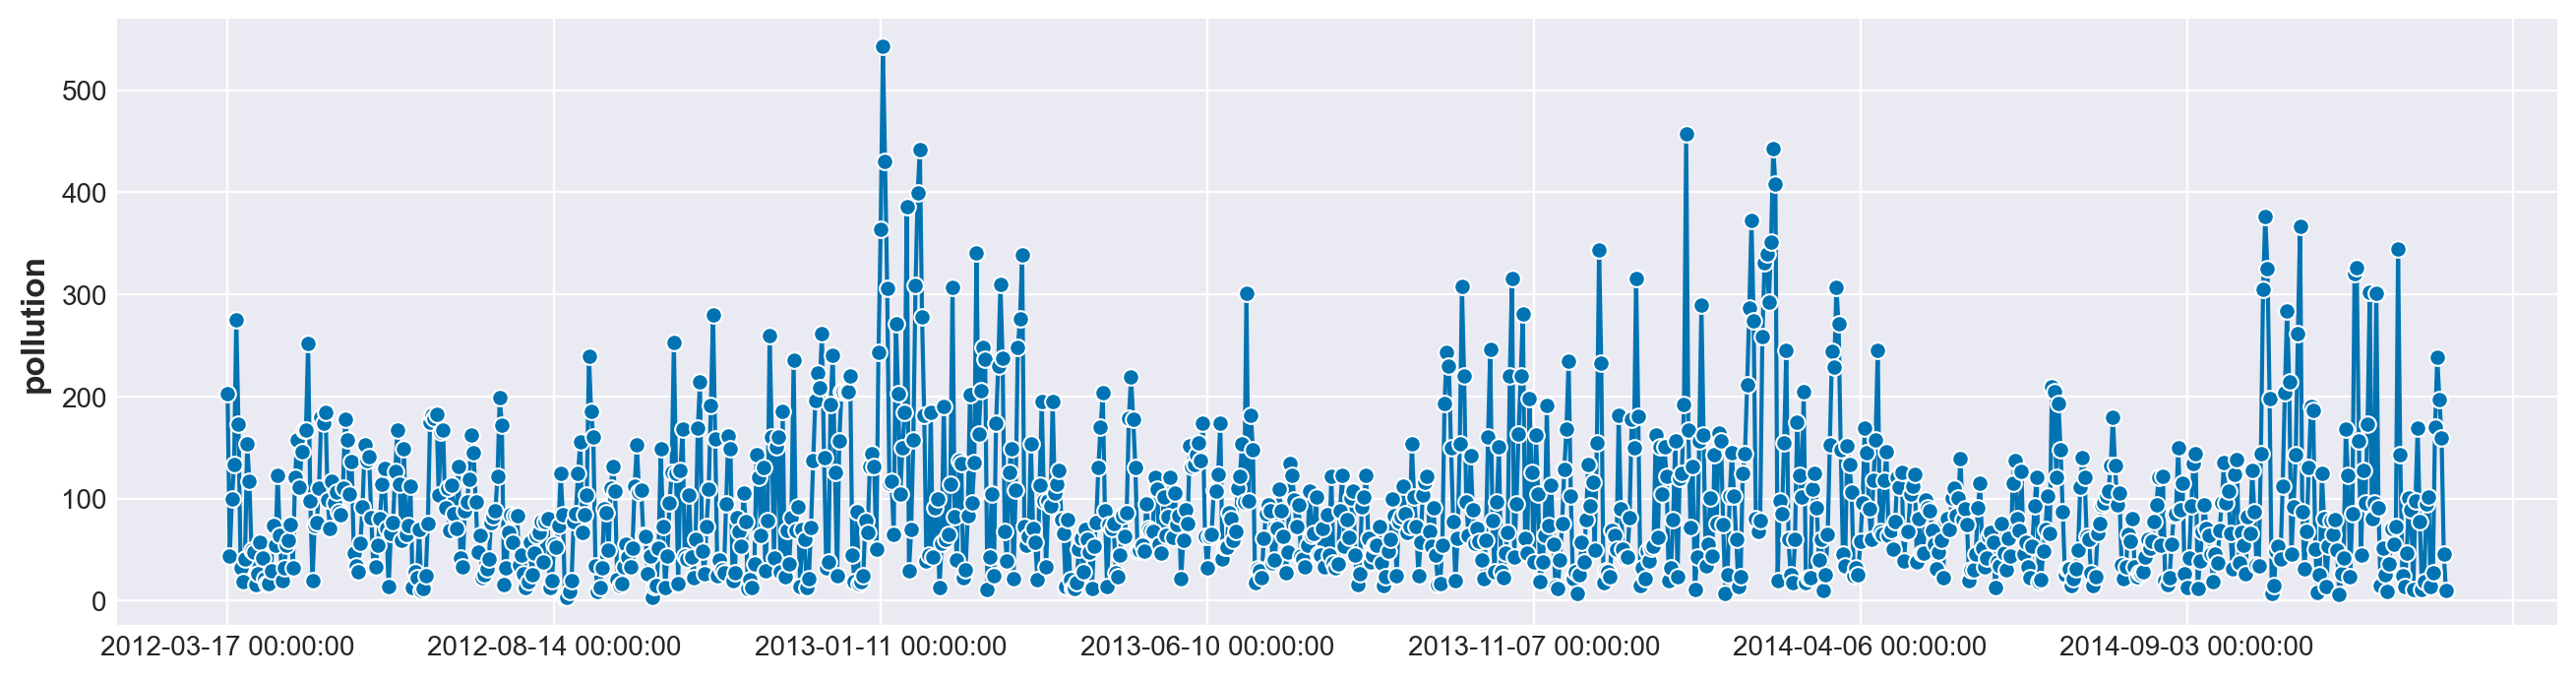

In [6]:
from statsmodels.tsa.stattools import adfuller

TEST_SIZE = 30
TARGET_COl = 'pollution'

plotting.plot_series(dataframe.tail(1020)[TARGET_COl])


adf_result = adfuller(dataframe[TARGET_COl])

print(f"ADF Test Statistic: {adf_result[0]}")
print(f"p-value: : {adf_result[1]}")

if adf_result[1] > 0.05 :
    print(f'The Series is non stationary, as P value {adf_result[1]} > 0.05')
else:
    print(f'The Series is  stationary, as P value {adf_result[1]} < 0.05')

In [7]:
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures

from sklearn.pipeline import Pipeline

adddatetime = Pipeline([
    ('datetime', DatetimeFeatures(
        variables="index",
        features_to_extract=["month", "quarter", "year", "week", "day_of_week", "day_of_month", "day_of_year", "weekend"],
        drop_original=True,
    )),
    ('cyclical', CyclicalFeatures(
        variables=["week", "month","day_of_week","day_of_month","day_of_year"]
    )),
])

dataframe_t adddatetime.fit_transform(dataframe)

dataframe_t.head()

SyntaxError: invalid syntax (3355506707.py, line 17)

train_xy and test_xy size  Test_Train Split: (1795, 7), (30, 7)

y_train and x_train size after Target Seperation: (1795,), (1795, 6)
y_test  and x_test  size after Target Seperation: (30,),  (30, 6)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

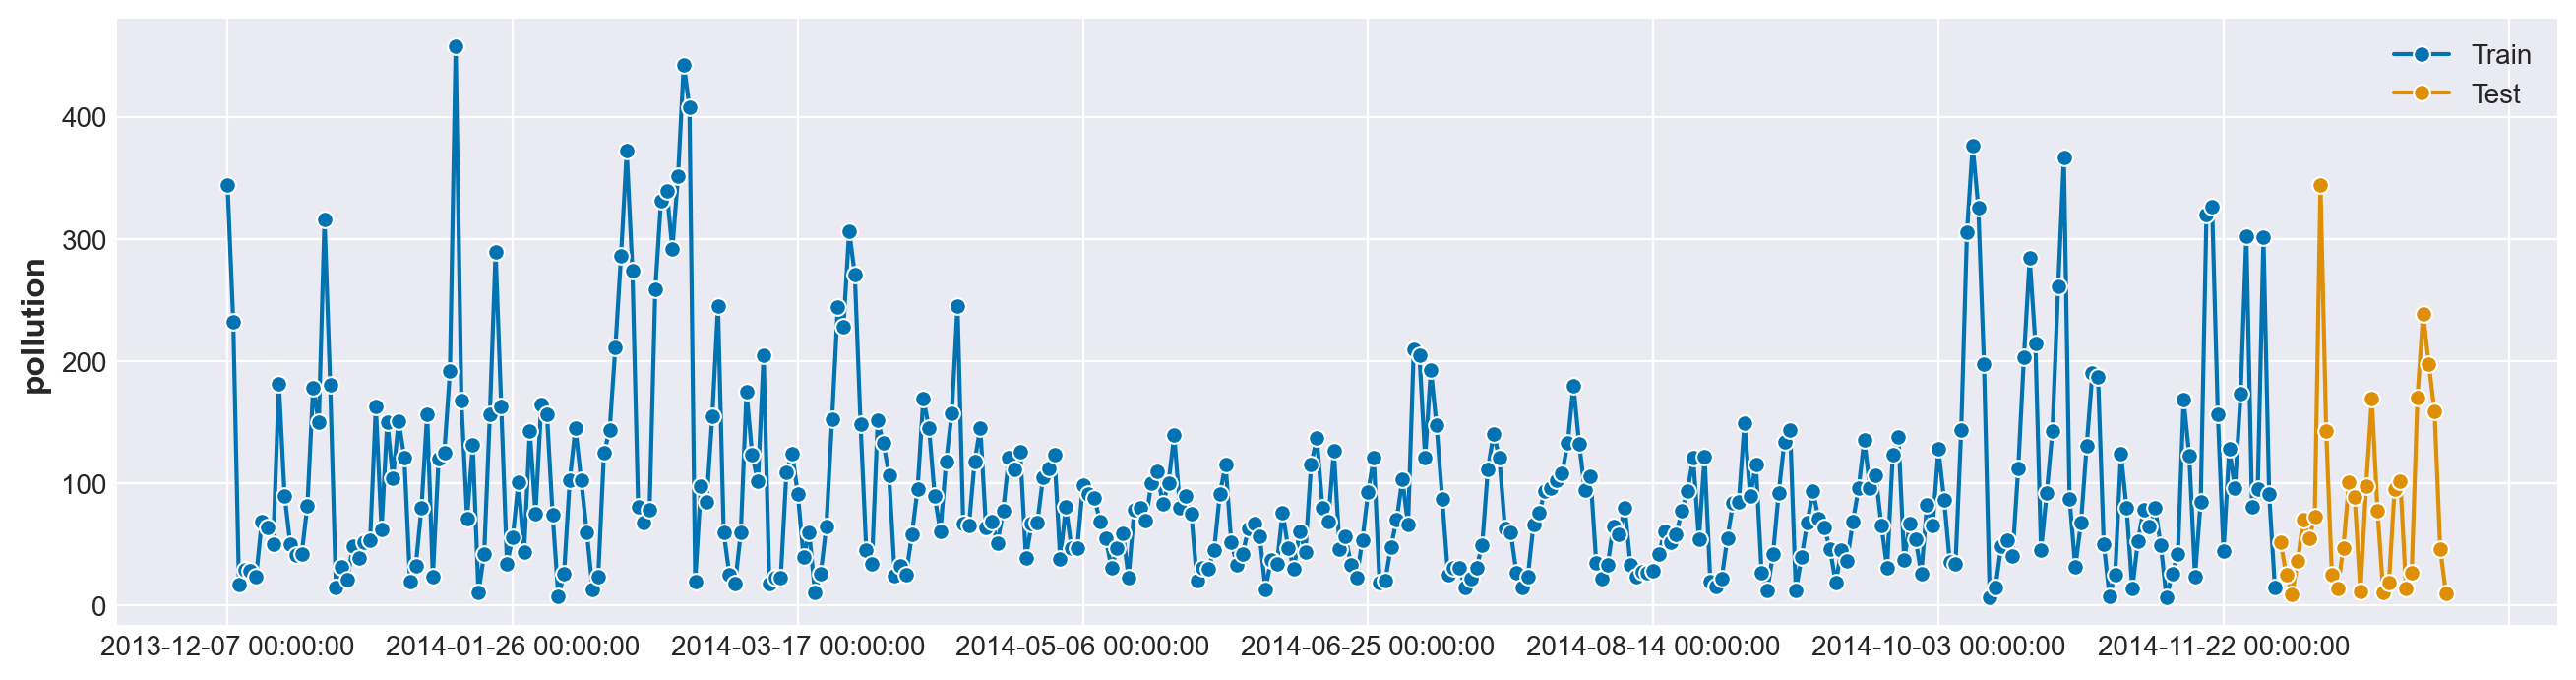

In [8]:
from sktime.utils import plotting
from sktime.forecasting.model_selection import temporal_train_test_split


train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)
print(f"train_xy and test_xy size  Test_Train Split: {train_xy.shape}, {test_xy.shape}", end='\n\n')

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train =  train_xy.drop(columns=[TARGET_COl]).copy(deep=True) 

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test =  test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size after Target Seperation: {y_train.shape}, {x_train.shape}")
print(f"y_test  and x_test  size after Target Seperation: {y_test.shape},  {x_test.shape}", end='\n\n')

plotting.plot_series(y_train.tail(360), y_test , labels=['Train','Test'])

### Forcasting all Columns single step [ Ignore]

MSE : 4843.327580861011
RMSE: 69.59401972052635
MAE : 51.97759773967525
MAPE: 1.4089158007858755



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

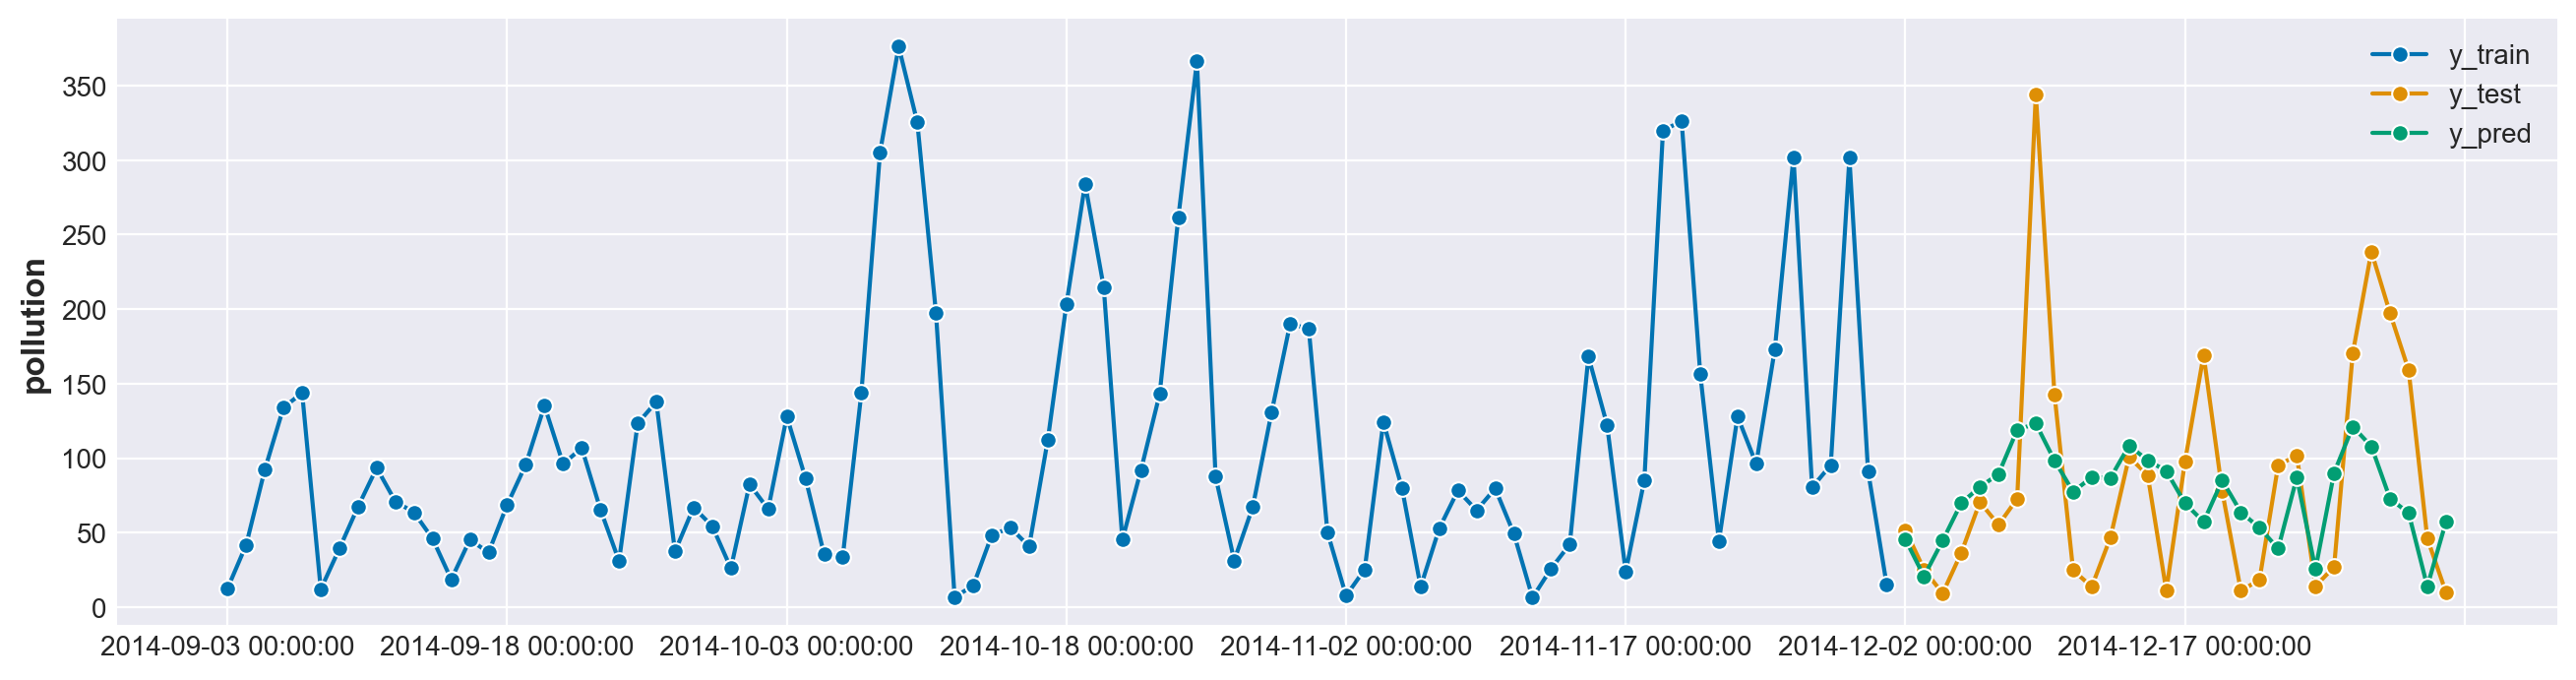

In [43]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression,LassoCV, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklego.preprocessing import ColumnDropper
from feature_engine.selection import DropFeatures

from sktime.forecasting.compose import ForecastingPipeline,make_reduction
from sktime.transformations.compose import FeatureUnion, Id
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.date import DateTimeFeatures
from sklearn.preprocessing import SplineTransformer
from sktime.transformations.series.fourier import FourierFeatures

mse  = MeanSquaredError(multioutput="uniform_average")
rmse = MeanSquaredError(square_root=True, multioutput='uniform_average')
mae  = MeanAbsoluteError(multioutput='uniform_average')
mape = MeanAbsolutePercentageError(multioutput='uniform_average')

rmd_state = 80

kwargs = {
    "lag_feature": {
        "lag": [1,2,3],
        "mean": [[1, 3],[1, 6]],
        "std": [[1, 3],[1, 6]],
    }
}

feat_colums = x_train.columns.to_list()


forecaster_pipe = ForecastingPipeline(
    [   #('drop_cols', ColumnDropper(['dewp'])),
        #("feat_sel_X", FeatureSelection(method="columns", columns=['dewp','press','wnd_spd','snow','rain'])),
        #("scale_X", TabularToSeriesAdaptor(StandardScaler())),
        ("union", FeatureUnion(
            [
                ("original", Id()),
                ("transformed", WindowSummarizer(truncate="bfill", target_cols=feat_colums, **kwargs)),
                ("date_features", DateTimeFeatures(ts_freq="D", feature_scope="comprehensive")),
                #("spliine", TabularToSeriesAdaptor(SplineTransformer(n_knots=4, degree=3, extrapolation='constant')))
            ]
        )),     
        ("scale_X", TabularToSeriesAdaptor(MinMaxScaler())),
        #("feat_sel_X", FeatureSelection(method="feature-importances", n_columns=15, random_state=0)),
        #("ff", FourierFeatures(sp_list=[7,30], fourier_terms_list=[1,1])),
        ("linear_forecaster", make_reduction(
                    #RandomForestRegressor(max_depth=9, min_samples_leaf=2,min_samples_split=7,n_estimators=500),
                    LinearRegression(),
                    window_length=3,
                    strategy="recursive",
                    )
        ),
    ])


fh=np.arange(1, 31)

forecaster_pipe.fit(y_train, x_train, fh)
y_pred = forecaster_pipe.predict(fh, X=x_test)


print(f'MSE : {mse(y_test, y_pred)}')
print(f'RMSE: {rmse(y_test, y_pred)}')
print(f'MAE : {mae(y_test, y_pred)}' )
print(f'MAPE: {mape(y_test, y_pred)}', end='\n\n')


plotting.plot_series(y_train[-90:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

MSE : 9243.585980805528
RMSE: 96.1435696279555
MAE : 80.17121625881603
MAPE: 2.7608328171093306



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

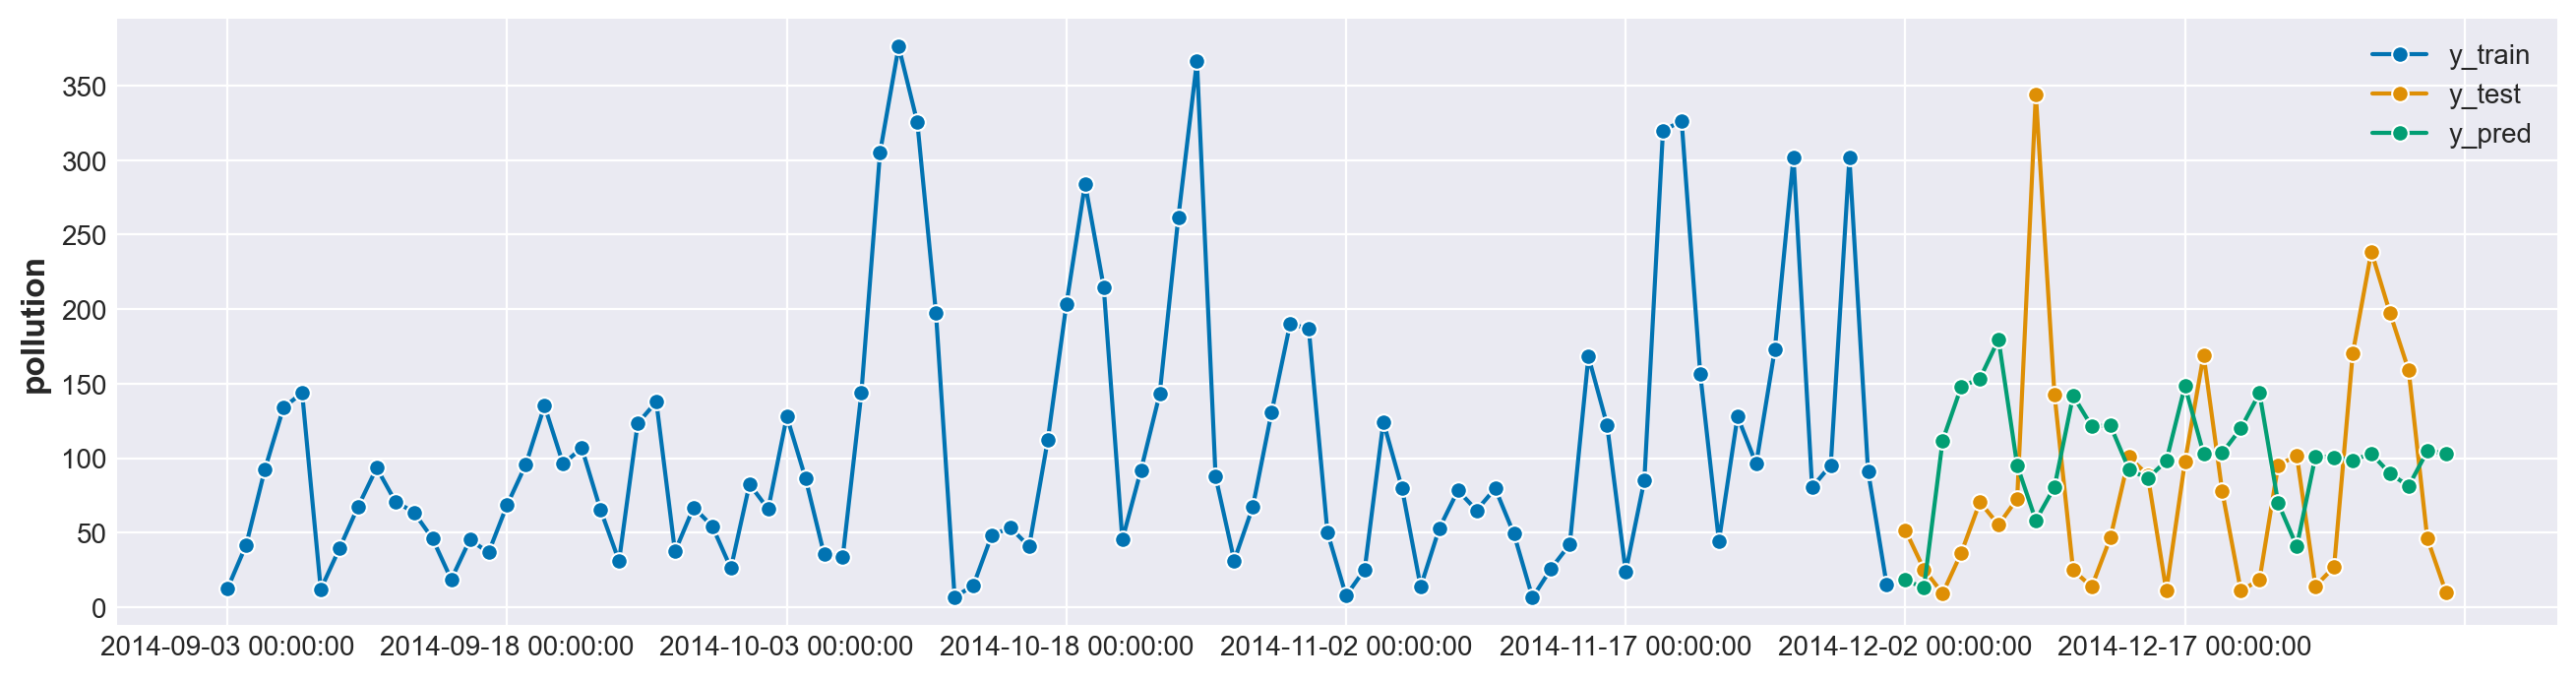

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression,LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklego.preprocessing import ColumnDropper
from feature_engine.selection import DropFeatures

from sktime.forecasting.compose import ForecastingPipeline,make_reduction, TransformedTargetForecaster
from sktime.transformations.compose import FeatureUnion, Id
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.feature_selection import FeatureSelection
from sktime.transformations.series.detrend import  Detrender, Deseasonalizer

rmd_state = 80

kwargs = {
    "lag_feature": {
        #"lag": [0],
        "mean": [[1, 3],[1, 6]],
        "std": [[1, 3],[1, 6]],
    }
}



forecaster_pipe = ForecastingPipeline(
    [   
        ("union", FeatureUnion(
            [
                ("original", Id()),
                ("transformed", WindowSummarizer(truncate="bfill", target_cols=feat_colums, **kwargs)),
                ("date_features", DateTimeFeatures(ts_freq="D", feature_scope="comprehensive")),
                #("ff", FourierFeatures(sp_list=[7, 365], fourier_terms_list=[3, 9]))
            ]
        )),     
        ("target_forecaster", TransformedTargetForecaster(
            [
                #("deseasonalize_3M", Deseasonalizer(model="additive", sp=3)),
                #("deseasonalize_12M", Deseasonalizer(model="additive", sp=12)),
                ("detrend", Detrender()),
                #("scale_y", TabularToSeriesAdaptor(MinMaxScaler())),
                ("lgb_forecaster", make_reduction(
                    estimator=LinearRegression(),
                    window_length=13,
                    strategy="direct",
                    )
                ),
            ]
        ))
    ])


fh=np.arange(1, 31)

forecaster_pipe.fit(y_train, x_train, fh)
y_pred = forecaster_pipe.predict(fh, X=x_test)


print(f'MSE : {mse(y_test, y_pred)}')
print(f'RMSE: {rmse(y_test, y_pred)}')
print(f'MAE : {mae(y_test, y_pred)}' )
print(f'MAPE: {mape(y_test, y_pred)}', end='\n\n')


plotting.plot_series(y_train[-90:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

### Prediction on Test Data

In [ ]:
print(f"forecaster.cutoff After Traing Before Predict : {forecaster.cutoff}")

y_predict = forecaster.predict(fh=fhzon)

print(f"forecaster.cutoff After Traing + Predict : {forecaster.cutoff}")
# y_predict.head()

### Plot Test Predictions

In [ ]:
fig, ax = plotting.plot_series(
    y_train.tail(60), y_test, y_predict, labels=["Train", "Test", "Prediction"]
)

### Training Score

In [ ]:
cross_validation = SlidingWindowSplitter(
    initial_window=int(y_train.shape[0] * 0.8),
    window_length=input_seq_len + ouput_seq_len,
    step_length=3,
)
losses = [MeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()]

results = evaluate(
    forecaster=forecaster, y=y_train, X=x_train, cv=cross_validation, scoring=losses
)

results[
    [
        "test_MeanSquaredError",
        "test_MeanAbsoluteError",
        "test_MeanAbsolutePercentageError",
    ]
].mean()

### Test Score

In [ ]:
for loss in losses:
    l = loss(y_test.copy(deep=True), y_predict)
    print(f"{loss.name} : {l}")

### Forecasting

In [ ]:
print(f"forecaster.cutoff After Traing + Predict {forecaster.cutoff}")

y_fcasted = forecaster.update(y_test.copy(deep=True), X=x_test, update_params=False)

print(f"forecaster.cutoff After Traing + Predict {forecaster.cutoff}")

y_fcasted = forecaster.predict(fh=fhzon)
y_fcasted.head()

### Plot Forecasting

In [ ]:
fig, ax = plotting.plot_series(
    y_test.copy(deep=True), y_fcasted, labels=["Past", "Forecasted"]
)